# YOLOv3 Architecture

In [1]:
"""
Implementation of YOLOv3 architecture
"""
 
import torch
import torch.nn as nn
 
""" 
Information about architecture config:
Tuple is structured by (filters, kernel_size, stride) 
Every conv is a same convolution. 
List is structured by "B" indicating a residual block followed by the number of repeats
"S" is for scale prediction block and computing the yolo loss
"U" is for upsampling the feature map and concatenating with a previous layer
"""
config = [
    (32, 3, 1),
    (64, 3, 2),
    ["B", 1],
    (128, 3, 2),
    ["B", 2],
    (256, 3, 2),
    ["B", 8],
    (512, 3, 2),
    ["B", 8],
    (1024, 3, 2),
    ["B", 4],  # To this point is Darknet-53
    (512, 1, 1),
    (1024, 3, 1),
    "S",
    (256, 1, 1),
    "U",
    (256, 1, 1),
    (512, 3, 1),
    "S",
    (128, 1, 1),
    "U",
    (128, 1, 1),
    (256, 3, 1),
    "S",
]
 
 
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bn_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=not bn_act, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky = nn.LeakyReLU(0.1)
        self.use_bn_act = bn_act
 
    def forward(self, x):
        if self.use_bn_act:
            return self.leaky(self.bn(self.conv(x)))
        else:
            return self.conv(x)
 
 
class ResidualBlock(nn.Module):
    def __init__(self, channels, use_residual=True, num_repeats=1):
        super().__init__()
        self.layers = nn.ModuleList()
        for repeat in range(num_repeats):
            self.layers += [
                nn.Sequential(
                    CNNBlock(channels, channels // 2, kernel_size=1),
                    CNNBlock(channels // 2, channels, kernel_size=3, padding=1),
                )
            ]
 
        self.use_residual = use_residual
        self.num_repeats = num_repeats
 
    def forward(self, x):
        for layer in self.layers:
            if self.use_residual:
                x = x + layer(x)
            else:
                x = layer(x)
 
        return x
 
 
class ScalePrediction(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.pred = nn.Sequential(
            CNNBlock(in_channels, 2 * in_channels, kernel_size=3, padding=1),
            CNNBlock(
                2 * in_channels, 5 * 3, bn_act=False, kernel_size=1
            ),
        )
 
    def forward(self, x):
        return (
            self.pred(x)
            .reshape(x.shape[0], 3, 5, x.shape[2], x.shape[3])
            .permute(0, 1, 3, 4, 2)
        )

#This module applies the math opperations from the YOLO paper to retrieve the true coordinates and with and height of the bboxes instead of doing this at a later stage.
class MathOperations(nn.Module):
    def __init__(self):
        super().__init__()
        self.sigmoid = nn.Sigmoid()
        self.anchors = (torch.tensor(CONFIG.ANCHORS) * torch.tensor(CONFIG.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)).to(CONFIG.DEVICE)
 
    """

    x is in the shape N x 3 x S x S x 5
    we want the last dimension to be in this order: [x, y, w, h, obj]
    In the forward we'll apply the mathematical operations described in both YOLO 9000 and YOLO V3 papers

    bx = sigma(tx) + cx
    by = sigma(ty) + cy
    bw = pw * exp(tw)
    bh = ph * exp(th)

    cx/cy = location of upper left corner of cell
    pw/ph = prior size of the anchor box
    t = vector before operation
    b = vector after operation

    """
    def forward(self, x, scale):
        # return  torch.cat([self.sigmoid(predictions[..., 1:3]), torch.exp(predictions[..., 3:5]) * anchors], dim=-1)
        return  torch.cat([self.sigmoid(x[..., 0:2]), torch.exp(x[..., 2:4]) * self.anchors[scale].reshape(1, 3, 1, 1, 2), self.sigmoid(x[..., 4:5])], dim=-1)
# N = 8
# S = 56
# anchors = torch.tensor(CONFIG.ANCHORS[0])
# print(anchors)
# x_test = torch.tensor([10, -20, -5, 1, 2000])
# x_test = x_test.repeat(N, 3, S, S, 1)
# print(x_test[0, 0, 0, 0])

# layer_test = MathOperations(0, anchors)
# output = layer_test(x_test)
# print(output[0,1,0,0])
 
 
class YOLOv3(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.in_channels = in_channels
        self.layers = self._create_conv_layers()
 
    def forward(self, x):
        outputs = []  # for each scale
        route_connections = []
        MathOperationsLayer = MathOperations()
        for layer in self.layers:
            if isinstance(layer, ScalePrediction):
                outputs.append(MathOperationsLayer(layer(x),len(outputs)))
                continue
 
            x = layer(x)
 
            if isinstance(layer, ResidualBlock) and layer.num_repeats == 8:
                route_connections.append(x)
 
            elif isinstance(layer, nn.Upsample):
                x = torch.cat([x, route_connections[-1]], dim=1)
                route_connections.pop()
 
        return outputs
 
    def _create_conv_layers(self):
        layers = nn.ModuleList()
        in_channels = self.in_channels
 
        for module in config:
            if isinstance(module, tuple):
                out_channels, kernel_size, stride = module
                layers.append(
                    CNNBlock(
                        in_channels,
                        out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=1 if kernel_size == 3 else 0,
                    )
                )
                in_channels = out_channels
 
            elif isinstance(module, list):
                num_repeats = module[1]
                layers.append(ResidualBlock(in_channels, num_repeats=num_repeats,))
 
            elif isinstance(module, str):
                if module == "S":
                    layers += [
                        ResidualBlock(in_channels, use_residual=False, num_repeats=1),
                        CNNBlock(in_channels, in_channels // 2, kernel_size=1),
                        ScalePrediction(in_channels // 2),
                    ]
                    in_channels = in_channels // 2
 
                elif module == "U":
                    layers.append(nn.Upsample(scale_factor=2),)
                    in_channels = in_channels * 3
 
        return layers

# Config

In [2]:
import albumentations as A
import cv2
import torch
 
from albumentations.pytorch import ToTensorV2

class Config:

  def __init__(self):
    self.BB_TRESHOLD = 50 #defines whats considered a large boundingbox for the filtering of the data
    self.DATA_PATH = '../wider_face/'
    self.INDEX_PATH_TRAIN = self.DATA_PATH + 'annotation/wider_face_train_bbx_gt.txt'
    self.INDEX_PATH_VAL = self.DATA_PATH + 'annotation/wider_face_val_bbx_gt.txt'
    self.IMAGE_STORE_PATH_TRAIN = self.DATA_PATH + 'train/'
    self.IMAGE_STORE_PATH_VAL = self.DATA_PATH + 'validation/'
    self.ANCHORS = [
      [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
      [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
      [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
    ]  # Note these have been rescaled to be between [0, 1]
  

    #TODO replace these by what we use
    self.DATASET = '/PASCAL_VOC'
    self.IMG_DIR = '/PASCAL_VOC/images/'
    self.LABEL_DIR = '/PASCAL_VOC/labels/'
    self.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    # UTILS.seed_everything()  # If you want deterministic behavior
    self.NUM_WORKERS = 0 #4 causes errors on windows to have more than 0
    self.BATCH_SIZE = 12
    self.IMAGE_SIZE = 416
    self.LEARNING_RATE = 1e-4
    self.WEIGHT_DECAY = 0 #1e-4 staat uit nu om te overfitten, kan aan tijdens echte trainen
    self.NUM_EPOCHS = 100
    self.CONF_THRESHOLD = 0.7#0.05
    self.MAP_IOU_THRESH = 0.25#0.5
    self.NMS_IOU_THRESH = 0.25#0.45
    self.S = [self.IMAGE_SIZE // 32, self.IMAGE_SIZE // 16, self.IMAGE_SIZE // 8]
    self.PIN_MEMORY = True
    self.LOAD_MODEL = False
    self.SAVE_MODEL = False
    self.CHECKPOINT_FILE = "..\checkpoint.pth.tar"
    
    self.ANCHORS = [
        [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
        [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
        [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
    ]  # Note these have been rescaled to be between [0, 1]
    
    self.scale = 1.1
    self.train_transforms = A.Compose(
        [
            A.LongestMaxSize(max_size=int(self.IMAGE_SIZE * self.scale)),
            A.PadIfNeeded(
                min_height=int(self.IMAGE_SIZE * self.scale),
                min_width=int(self.IMAGE_SIZE * self.scale),
                border_mode=cv2.BORDER_CONSTANT,
            ),
            A.RandomCrop(width=self.IMAGE_SIZE, height=self.IMAGE_SIZE),
            A.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0.6, p=0.4),
            A.HorizontalFlip(p=0.5),
            A.Blur(p=0.1),
            A.CLAHE(p=0.1),
            A.Posterize(p=0.1),
            A.ToGray(p=0.1),
            A.ChannelShuffle(p=0.05),
            A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
            ToTensorV2(),
        ],
        bbox_params=A.BboxParams(format="coco", min_visibility=0.4, label_fields=[],),
    )

    self.test_transforms = A.Compose(
        [
            A.LongestMaxSize(max_size=self.IMAGE_SIZE),
            A.PadIfNeeded(
                min_height=self.IMAGE_SIZE, min_width=self.IMAGE_SIZE, border_mode=cv2.BORDER_CONSTANT
            ),
            A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
            ToTensorV2(),
        ],
        bbox_params=A.BboxParams(format="coco", min_visibility=0.4, label_fields=[]),
    )

CONFIG = Config()

# Utils

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import random
import torch
import torchvision

from collections import Counter
from torch.utils.data import DataLoader
from tqdm import TqdmTypeError
from torchvision.ops import nms, box_iou, box_convert

class Utils():
    
    """
        This function calculates the intersection over union of two sets of
        bounding boxes. It takes the two tensors of bounding boxes and a 
        string representing their format as input. With the formats being
        defined as the following by torchvision:
        
        ‘xyxy’: boxes are represented via corners, x1, y1 being top left and 
                x2, y2 being bottom right. This is the format that torchvision 
                utilities expect.

        ‘xywh’: boxes are represented via corner, width and height, x1, y2 
                being top left, w, h being width and height.

        ‘cxcywh’: boxes are represented via centre, width and height, cx, cy 
                being center of box, w, h being width and height.
    
    """
    def intersection_over_union(self,bboxes1,bboxes2,format = "cxcywh"):
        assert type(bboxes1) == torch.Tensor and type(bboxes2) == torch.Tensor, "One or both of the bboxes is not a torch.Tensor"
        bboxes1.to(CONFIG.DEVICE)
        bboxes2.to(CONFIG.DEVICE)
        
        if (format == "cxcywh"):
            return box_iou(box_convert(bboxes1,"cxcywh", "xyxy"),box_convert(bboxes2,"cxcywh", "xyxy"))
        elif (format == "xywh"):
            return box_iou(box_convert(bboxes1,"xywh", "xyxy"),box_convert(bboxes2,"xywh", "xyxy"))
        else: # format == "xyxy"
            return box_iou(bboxes1,bboxes2)
    
    
    def iou_width_height(self, boxes1, boxes2):
        """
        Parameters:
            boxes1 (tensor): width and height of the first bounding boxes
            boxes2 (tensor): width and height of the second bounding boxes
        Returns:
            tensor: Intersection over union of the corresponding boxes
        """
        intersection = torch.min(boxes1[..., 0], boxes2[..., 0]) * torch.min(
            boxes1[..., 1], boxes2[..., 1]
        )
        union = (
            boxes1[..., 0] * boxes1[..., 1] + boxes2[..., 0] * boxes2[..., 1] - intersection
        )
        return intersection / union

    """
        This function converts a list of bboxes to the targets for each scale
        input bboxes: a list of bboxes in the form [x, y, width, height]
        returns: a list of size 3 with a target vector for each scale.
    """
    "Unit test needed"
    def bboxes_to_cellvectors(self, bboxes, anchors, S, ignore_iou_thresh):
        num_anchors = anchors.shape[0]
        num_anchors_per_scale = num_anchors // 3

        # Below assumes 3 scale predictions (as paper) and same num of anchors per scale
        targets = [torch.zeros((num_anchors // 3, S, S, 5)) for S in S]

        for box in bboxes:

            iou_anchors = UTILS.iou_width_height(torch.tensor(box[2:4]), anchors)  #get a list of the IOU for all anchor boxes for this bounding box
            anchor_indices = iou_anchors.argsort(descending=True, dim=0)  #sort the list of IOU's to get the largest values first

            x, y, width, height = box
            has_anchor = [False] * 3  # each scale should have one anchor (we want to pick one anchor per scale for each bounding box)

            for anchor_idx in anchor_indices: #find an anchor that fits
                scale_idx = anchor_idx // num_anchors_per_scale #determine which scale we're working with
                anchor_on_scale = anchor_idx % num_anchors_per_scale #determines the anchor number on that scale
                s = S[scale_idx] #get the grid size
                i, j = int(s * y), int(s * x)  #determine the cell within the grid cell

                anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 4] #check the objectness value for this anchor to see if its already taken by by some other bbox

                if not anchor_taken and not has_anchor[scale_idx]:

                    targets[scale_idx][anchor_on_scale, i, j, 4] = 1  #set objectness prediction target to 1 (as there is an object here)
                    x_cell, y_cell = s * x - j, s * y - i  #  determine the x and y coordinates relative to the cell, both between [0,1]

                    box_coordinates = torch.tensor(
                        [x_cell, y_cell, width, height]
                    )
                    
                    targets[scale_idx][anchor_on_scale, i, j, 0:4] = box_coordinates 

                    has_anchor[scale_idx] = True  #notify that the bbox has an anchor for this scale

                elif not anchor_taken and iou_anchors[anchor_idx] > ignore_iou_thresh: #if there is already an anchor for this bbox (so with a better iou)
                    targets[scale_idx][anchor_on_scale, i, j, 4] = -1  # set objectness of this anchor to -1 to signal to ignore prediction


        return targets


    """
        This function converts the cellvector of one scale back to a list of bounding boxes
        input cellvectors: cellvector of one scale (anchors per scale, S, S, 6))
        input anchors: a list of anchors for this scale only
        returns: a list of bounding boxes formatted as (x, y, w, h, obj_score)
    """
    "Unit test needed"
    def cellvector_to_bboxes(self, cellvector, anchors):

        cellvector = cellvector.to("cpu")

        S = cellvector.shape[2]     # get S from the size of the cellvector

        # the following code adds the index of the cell, both i and j, to the x and y positioin of the box relative to the cell. This results in the x and y relative to the image after dividing by the size of the grid
        cell_indices_x = (
            torch.arange(S)
            .repeat(3, S, 1)
        )

        cell_indices_y = cell_indices_x.permute(0, 2, 1)

        scale = 1/S
        x = scale * (cellvector[..., 0] + cell_indices_x)  # x = (cx + i) / grid_scale
        y = scale * (cellvector[..., 1] + cell_indices_y)  # y = (cy + j) / grid_scale
        w = cellvector[...,2]
        h = cellvector[...,3]
        obj_pred = cellvector[...,4]

        bboxes = torch.stack((x, y, w, h, obj_pred), dim=-1).reshape(len(anchors) * S * S, 5)

        return bboxes.tolist()

    """
        This function converts the cellvectors of all scales back to a list of bounding boxes
        input cellvectors: list with shape (#_of_scales,) of cellvectors per scale with shape (anchors per scale, S, S, 6))
        input anchors: The complete list of list of anchors
        returns: a list of bounding boxes formatted as (x, y, w, h, obj_score)
    """
    "Unit test needed"
    def cellvectors_to_bboxes(self, cellvectors, anchors):
        assert len(cellvectors) == len(anchors)

        batch_size = cellvectors[0].shape[0]

        bboxes = []
        for i in range(batch_size):
            bboxes_batch = []
            for scale_idx, cellvector in enumerate(cellvectors):
                bboxes_batch.extend(self.cellvector_to_bboxes(cellvector[i], anchors[scale_idx]))
            bboxes.append(bboxes_batch)

        return bboxes
    
    
    "Unit test needed"
    def non_max_suppression(self, bboxes, iou_threshold=CONFIG.NMS_IOU_THRESH, threshold=CONFIG.CONF_THRESHOLD, box_format="corners"):
        """
        Video explanation of this function:
        https://youtu.be/YDkjWEN8jNA
        Does Non Max Suppression given bboxes
        Parameters:
            bboxes (list): list of lists containing all bboxes with each bboxes
            specified as [x1, y1, x2, y2, obj_socre]
            iou_threshold (float): threshold where predicted bboxes is correct
            threshold (float): threshold to remove predicted bboxes (independent of IoU)
            box_format (str): "midpoint" or "corners" used to specify bboxes
        Returns:
            list: bboxes after performing NMS given a specific IoU threshold
        """
        assert type(bboxes) == list
    
        bboxes = [box for box in bboxes if box[4] > threshold]
        
        if len(bboxes) > 0:
            boxes = box_convert(torch.tensor([box[:4] for box in bboxes]).to(CONFIG.DEVICE),'xywh', 'xyxy')
            scores = torch.tensor([box[4] for box in bboxes]).to(CONFIG.DEVICE)

            return [bboxes[i] for i in nms(boxes, scores, iou_threshold).tolist()]
        else:
            return bboxes


    "Unit test needed"
    def mean_average_precision(self, pred_boxes, true_boxes, iou_threshold=CONFIG.MAP_IOU_THRESH):
        """
        Video explanation of this function:
        https://youtu.be/FppOzcDvaDI
        This function calculates mean average precision (mAP)
        Parameters:
            pred_boxes (list): list of list of lists containing all bboxes with each bboxes
            specified as [class_prediction, prob_score, x, y, w, h] for each training example
            true_boxes (list): Similar as pred_boxes except all the correct ones
            iou_threshold (float): threshold where predicted bboxes is correct
        Returns:
            float: mAP value across all classes given a specific IoU threshold
        """

        # Convert list of lists of bounding boxes per sample to one list of 
        # bounding boxes with the sample as item of a bounding box.
        # This allows sorting based on confidence level
        pred_boxes = [[sample_idx] + bbox for sample_idx, sample in enumerate(pred_boxes) for bbox in sample]
        true_boxes = [[sample_idx] + bbox for sample_idx, sample in enumerate(true_boxes) for bbox in sample]

        # Tensor to keep track of already found bounding boxes.
        found = torch.zeros(len(true_boxes))

        # Sort detections based on confidence, this is the ranking for mAP
        pred_boxes.sort(key=lambda x: x[4], reverse=True)

        # Make list of TP and FP to keep track of them for each step
        TP = torch.zeros(len(pred_boxes))
        FP = torch.zeros(len(pred_boxes))

        # Loop trough the sorted detections starting from highest confidence (rank)
        for rank, detection in enumerate(tqdm(pred_boxes)):

            # Find all possible ground_truths for this detection
            ground_truth = []
            ground_truth_id = []
            for id, bbox in enumerate(true_boxes):
                if bbox[0] == detection[0] and bbox[1] == detection[1] and not found[id]:
                    ground_truth.append(bbox[-4:])
                    ground_truth_id.append(id)

            ground_truth = torch.tensor(ground_truth)

            # Add dimension to detection for the torchvision box_iou function
            detection = torch.Tensor(detection[-4:]).unsqueeze(0)

            # if there is no ground truth, false positive by default
            if ground_truth.shape[0] <= 0:
                FP[rank] = 1
                continue

            IOU = UTILS.intersection_over_union(detection,ground_truth)
            # print("IOU matrix: {}".format(IOU))

            best_iou = torch.max(IOU)
            
            # if rank < 10:
            #   self.plot_boxes(detection.tolist(), ground_truth.tolist())
            #   print("detetion: {}".format(detection))
            #   print("ground_truth: {}".format(ground_truth))
            #   print("iou_tensor: {}".format(IOU))
            #   print("best_iou: {}, rank: {}".format(best_iou, rank))

            best_iou_idx = torch.argmax(IOU)

            if best_iou >= iou_threshold:
                found[ground_truth_id[best_iou_idx]] = 1
                TP[rank] = 1
            else:
                FP[rank] = 1

        #comulative sum of tp and fp to be able to calculate precision and recall at each rank
        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        
        #calculate recall and precision at each rank
        recalls = TP_cumsum / len(true_boxes) #TP / (TP + FN)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum)  #TP / TP + FP

        #add 1 to precision because before rank 0 the precision is 100%
        precisions = torch.cat((torch.tensor([1]), precisions))

        #add 0 to recalls because before rank 0 the recall is 0%
        recalls = torch.cat((torch.tensor([0]), recalls))

        #get area under precision-recall graph using trapezoid rule
        mAP = torch.trapz(precisions, recalls)
        return mAP.item()


    # def plot_boxes(self, predictions, true_boxes, image=None):

    #     fig, ax = plt.subplots(1)

    #     height, width = 1, 1
    #     if not image == None:
    #         im = np.array(image)
    #         print(im.shape)
    #         height, width, _ = im.shape
    #         ax.imshow(im)

    #     for box in true_boxes:
    #         box = box[:4]
    #         upper_left_x = box[0] - box[2] / 2
    #         upper_left_y = box[1] - box[3] / 2
    #         rect = patches.Rectangle(
    #             (upper_left_x * width, upper_left_y * height),
    #             box[2] * width,
    #             box[3] * height,
    #             linewidth=2,
    #             edgecolor="green",
    #             facecolor="none",
    #         )
    #         # Add the patch to the Axes
    #         ax.add_patch(rect)

    #     for box in predictions:
    #         box = box[-4:]
    #         upper_left_x = box[0] - box[2] / 2
    #         upper_left_y = box[1] - box[3] / 2
    #         rect = patches.Rectangle(
    #             (upper_left_x * width, upper_left_y * height),
    #             box[2] * width,
    #             box[3] * height,
    #             linewidth=2,
    #             edgecolor="blue",
    #             facecolor="none",
    #         )
    #         # Add the patch to the Axes
    #         ax.add_patch(rect)

    #     plt.show()

    def plot_image(self, image, boxes):
        """Plots predicted bounding boxes on the image"""

        im = np.array(image)
        height, width, _ = im.shape
    
        # Create figure and axes
        fig, ax = plt.subplots(1)
        # Display the image
        ax.imshow(im)
    
        # box[0] is x midpoint, box[2] is width
        # box[1] is y midpoint, box[3] is height
    
        # Create a Rectangle patch
        for box in boxes:
            assert len(box) == 5, "box should contain x, y, width, height, obj_confidence, "
            box = box[:4]
            upper_left_x = box[0] - box[2] / 2
            upper_left_y = box[1] - box[3] / 2
            rect = patches.Rectangle(
                (upper_left_x * width, upper_left_y * height),
                box[2] * width,
                box[3] * height,
                linewidth=2,
                edgecolor="blue",
                facecolor="none",
            )
            # Add the patch to the Axes
            ax.add_patch(rect)
    
        plt.show()

    def get_evaluation_bboxes3(self, 
        loader,
        model,
        iou_threshold = CONFIG.NMS_IOU_THRESH,
        anchors = CONFIG.ANCHORS,
        threshold = CONFIG.CONF_THRESHOLD,
        box_format="midpoint",
        device="cuda",
    ):

        # Make sure model is in eval before get bboxes
        model.eval()

        all_pred_boxes = []
        all_true_boxes = []

        #go over all batches in the loader
        for (x, y) in tqdm(loader):

            #forward the entire batch trough the model to get a list of predictions for each batch
            #shape of predictions = (#_of_scales = 3,) with tensors of the form (batch_size, #_of_anchors, S, S, 5)
            x = x.to(CONFIG.DEVICE)
            with torch.no_grad():
                predictions = model(x)

            batch_size = y[0].shape[0]

            bboxes_true_batch = UTILS.cellvectors_to_bboxes(y, anchors)

            for bboxes_true in bboxes_true_batch:
                bboxes_true = UTILS.non_max_suppression(bboxes_true)
                all_true_boxes.append(bboxes_true)

            bboxes_pred_batch = UTILS.cellvectors_to_bboxes(predictions, anchors)

            for bboxes_pred in bboxes_pred_batch:
                bboxes_pred = UTILS.non_max_suppression(bboxes_pred)
                all_pred_boxes.append(bboxes_pred)

        return all_pred_boxes, all_true_boxes

    def plot_examples(self, 
        loader,
        model,
        number_of_examples = 10,
        iou_threshold = CONFIG.NMS_IOU_THRESH,
        anchors = CONFIG.ANCHORS,
        threshold = CONFIG.CONF_THRESHOLD,
        box_format="midpoint",
        device="cuda",
    ):

        assert loader.batch_size == 1

        # Make sure model is in eval before get bboxes
        model.eval()
        train_idx = 0
        all_pred_boxes = []
        all_true_boxes = []
        for batch_idx, (x, labels, true_bboxes) in enumerate(loader):

            print(true_bboxes.shape)

            image = x.squeeze().permute(1,2,0)
            x = x.to(CONFIG.DEVICE)
    
            with torch.no_grad():
                predictions = model(x)
    
            bboxes = []
            for scale_idx in range(3):
                S = predictions[scale_idx].shape[2]
                anchor = torch.tensor([*anchors[scale_idx]]).to(CONFIG.DEVICE) * S
                boxes_scale_i =self.cells_to_bboxes(
                    predictions[scale_idx], anchor, S=S, is_preds=True
                )
                for idx, (box) in enumerate(boxes_scale_i):
                    bboxes += box

            nms_boxes = self.non_max_suppression(
                bboxes,
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )

            UTILS.plot_boxes(nms_boxes[:50], true_bboxes.squeeze(0), image)


    
        model.train()
    
    
    # def cells_to_bboxes(self, predictions, anchors, S, is_preds=True):
    #     """
    #     Scales the predictions coming from the model to
    #     be relative to the entire image such that they for example later
    #     can be plotted or.
    #     INPUT:
    #     predictions: tensor of size (N, 3, S, S,5)
    #     anchors: the anchors used for the predictions
    #     S: the number of cells the image is divided in on the width (and height)
    #     is_preds: whether the input is predictions or the true bounding boxes
    #     OUTPUT:
    #     converted_bboxes: the converted boxes of sizes (N, num_anchors * S * S, 1+5) with class index,
    #                         object score, bounding box coordinates
    #     """
    #     BATCH_SIZE = predictions.shape[0]
    #     num_anchors = len(anchors)
    #     box_predictions = predictions[..., 1:5]

    #     if is_preds:
    #         anchors = anchors.reshape(1, len(anchors), 1, 1, 2)
    #         box_predictions[..., 0:2] = torch.sigmoid(box_predictions[..., 0:2])
    #         box_predictions[..., 2:] = torch.exp(box_predictions[..., 2:]) * anchors
    #         scores = torch.sigmoid(predictions[..., 0:1])
    #         best_class = torch.argmax(predictions[..., 5:], dim=-1).unsqueeze(-1)
    #     else:
    #         scores = predictions[..., 0:1]
    #         best_class = predictions[..., 5:6]
    
    #     cell_indices = (
    #         torch.arange(S)
    #         .repeat(predictions.shape[0], 3, S, 1)
    #         .unsqueeze(-1)
    #         .to(predictions.device)
    #     )
    #     x = 1 / S * (box_predictions[..., 0:1] + cell_indices)
    #     y = 1 / S * (box_predictions[..., 1:2] + cell_indices.permute(0, 1, 3, 2, 4))
    #     w_h = 1 / S * box_predictions[..., 2:4]
    #     converted_bboxes = torch.cat((best_class, scores, x, y, w_h), dim=-1).reshape(BATCH_SIZE, num_anchors * S * S, 6)
    #     return converted_bboxes.tolist()
    
    
    def get_mean_std(self, loader):
        # var[X] = E[X**2] - E[X]**2
        channels_sum, channels_sqrd_sum, num_batches = 0, 0, 0
    
        for data, _ in tqdm(loader):
            channels_sum += torch.mean(data, dim=[0, 2, 3])
            channels_sqrd_sum += torch.mean(data ** 2, dim=[0, 2, 3])
            num_batches += 1
    
        mean = channels_sum / num_batches
        std = (channels_sqrd_sum / num_batches - mean ** 2) ** 0.5
    
        return mean, std
    
    
    def save_checkpoint(self, model, optimizer, filename="my_checkpoint.pth.tar"):
        print("=> Saving checkpoint")
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        torch.save(checkpoint, filename)
    
    
    def load_checkpoint(self, checkpoint_file, model, optimizer, lr):
        print("=> Loading checkpoint")
        checkpoint = torch.load(checkpoint_file, map_location=CONFIG.DEVICE)
        model.load_state_dict(checkpoint["state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer"])
    
        # If we don't do this then it will just have learning rate of old checkpoint
        # and it will lead to many hours of debugging \:
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
    
    
    def get_loaders(self):

        train_dataset = WIDER_Dataset(
            CONFIG.INDEX_PATH_TRAIN, 
            CONFIG.IMAGE_STORE_PATH_TRAIN, 
            transform=CONFIG.test_transforms
        )

        test_dataset = WIDER_Dataset(
            CONFIG.INDEX_PATH_VAL, 
            CONFIG.IMAGE_STORE_PATH_VAL, 
            transform=CONFIG.test_transforms
        )

        train_dataset_validation = WIDER_Dataset(
            CONFIG.INDEX_PATH_TRAIN, 
            CONFIG.IMAGE_STORE_PATH_TRAIN, 
            transform=CONFIG.test_transforms,
            max_size=4
        )
        
        train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=CONFIG.BATCH_SIZE,
            num_workers=CONFIG.NUM_WORKERS,
            pin_memory=CONFIG.PIN_MEMORY,
            shuffle=True,
            drop_last=False,
        )

        test_loader = DataLoader(
            dataset=test_dataset,
            batch_size=CONFIG.BATCH_SIZE,
            num_workers=CONFIG.NUM_WORKERS,
            pin_memory=CONFIG.PIN_MEMORY,
            shuffle=False,
            drop_last=False,
        )

        train_loader_validation = DataLoader(
            dataset=train_dataset_validation,
            batch_size=1,
            num_workers=0,
            pin_memory=CONFIG.PIN_MEMORY,
            shuffle=False,
            drop_last=False,
        )
    
        return train_loader, test_loader, train_loader_validation

    def plot_couple_examples(self, model, loader, thresh, iou_thresh, anchors):
        model.eval()
        x, y = next(iter(loader))
        x = x.to("cuda")
        with torch.no_grad():
            out = model(x)
            bboxes = [[] for _ in range(x.shape[0])]
            for i in range(3):
                batch_size, A, S, _, _ = out[i].shape
                anchor = anchors[i]
                boxes_scale_i = cells_to_bboxes(
                    out[i], anchor, S=S, is_preds=True
                )
                for idx, (box) in enumerate(boxes_scale_i):
                    bboxes[idx] += box
    
            model.train()
    
        for i in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[i], iou_threshold=iou_thresh, threshold=thresh, box_format="midpoint",
            )
            self.plot_image(x[i].permute(1,2,0).detach().cpu(), nms_boxes)

    def evaluate_model(self, test_loader, model):

        model.eval()

        pred_boxes, true_boxes = UTILS.get_evaluation_bboxes3(
                        test_loader,
                        model
                    )
        
        mAP = UTILS.mean_average_precision(true_boxes=true_boxes, pred_boxes=pred_boxes)

        
        # class_accuracy, no_obj_accuracy, obj_accuracy = UTILS.check_class_accuracy(model, test_loader, threshold=CONFIG.CONF_THRESHOLD)

        return mAP#, class_accuracy, no_obj_accuracy, obj_accuracy

    def seed_everything(self, seed=42):
        os.environ['PYTHONHASHSEED'] = str(seed)
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

UTILS = Utils()

# Dataset

torch.Size([1, 3, 13, 13, 5])
tensor([0.4067, 0.4819, 0.0107, 0.0146, 1.0000])
tensor([0.0034, 0.4502, 0.0068, 0.0078, 1.0000])
tensor([0.1270, 0.8755, 0.0137, 0.0166, 1.0000])
tensor([0.3667, 0.5962, 0.0166, 0.0244, 1.0000])
tensor([0.3745, 0.0786, 0.0146, 0.0166, 1.0000])
tensor([0.1934, 0.2310, 0.0176, 0.0146, 1.0000])
tensor([0.2344, 0.4658, 0.0156, 0.0195, 1.0000])
tensor([0.0151, 0.2817, 0.0166, 0.0186, 1.0000])
tensor([0.7290, 0.8721, 0.0205, 0.0176, 1.0000])
tensor([0.2778, 0.7959, 0.0225, 0.0215, 1.0000])
tensor([0.1821, 0.0625, 0.0225, 0.0293, 1.0000])
tensor([0.0767, 0.6343, 0.0107, 0.0146, 1.0000])
tensor([0.0479, 0.7231, 0.0137, 0.0166, 1.0000])
tensor([0.5840, 0.4375, 0.0098, 0.0117, 1.0000])
tensor([0.9297, 0.0659, 0.0156, 0.0166, 1.0000])
tensor([0.2563, 0.4468, 0.0205, 0.0205, 1.0000])
tensor([0.8623, 0.6499, 0.0156, 0.0166, 1.0000])
tensor([0.2988, 0.4248, 0.0117, 0.0156, 1.0000])
tensor([0.4731, 0.3804, 0.0107, 0.0146, 1.0000])
tensor([0.6436, 0.3833, 0.0215, 0.0166,

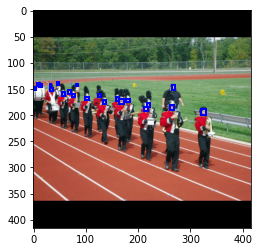

In [4]:
"""
Creates a Pytorch dataset to load the WIDER face dataset
"""

import numpy as np
import os
import pandas as pd
import torch
import albumentations


from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader



ImageFile.LOAD_TRUNCATED_IMAGES = True

def clamp(n, minn, maxn):
    return max(min(maxn, n), minn)


"""
This function returns a dictionary containing all training samples, for each sample containing the image location ("file_name") and defention of the bounding boxes ("bounding_boxes")
returns: the above discribed dict
"""
def read_data_index(index_path, skip_big_bb = False):
  training_set = []

  f = open(index_path, "r")
  while True:
    file_name = f.readline().strip()

    if not file_name: break

    incl = True #A boolean that tracks whether an image includes ANY large faces, if this bool is set to false the whole image will be skipped
                        # (in the case that skip_big_bb = True)
    boxes = []
    isSmall = []
    box_count = int(f.readline())
    if box_count >= 1:
      for i in range(box_count):
        box = f.readline().strip().split(' ')

        treshold = CONFIG.BB_TRESHOLD 
        if int(box[2]) < treshold:
            box = tuple([int(x) for x in box])
            boxes.append(box)
        elif not skip_big_bb:
            box = tuple([int(x) for x in box]) 
            boxes.append(box)
        else:
            incl = False
        
    else:
        next(f)

    if incl:
        instance = {
            "file_name": file_name,
            "bounding_boxes": boxes
            }

        training_set.append(instance)
        # print("new instance: " + str(instance))

  return training_set



class WIDER_Dataset(Dataset):
    def __init__(
        self,
        index_path,
        image_store_path,
        transform=None,
        max_size=None,
        anchors=CONFIG.ANCHORS,
        image_size=CONFIG.IMAGE_SIZE,
        S=CONFIG.S
    ):
        self.index_path = index_path
        self.image_store_path = image_store_path
        self.data_index = read_data_index(index_path)
        self.max_size = max_size
        self.transform = transform
        self.S = S
        self.anchors = torch.tensor(anchors[0] + anchors[1] + anchors[2])  # for all 3 scales
        self.num_anchors = self.anchors.shape[0]
        self.num_anchors_per_scale = self.num_anchors // 3
        self.ignore_iou_thresh = 0.5
        self.DEFAULT_FACE_CLASS = 1

    def __len__(self):
        return (len(self.data_index) if not self.max_size else self.max_size)

    def __getitem__(self, index):

        index_item = self.data_index[index]
        bboxes = index_item.get('bounding_boxes')
        img_path = self.image_store_path + index_item.get('file_name')

        image = Image.open(img_path).convert("RGB")
        image = np.array(image)

        bboxes = [[bbox[0],bbox[1],bbox[2],bbox[3]] if bbox[2] > 0 and bbox[3] > 0 else 
                [bbox[0],bbox[1],bbox[2],1] if bbox[2] > 0 else 
                [bbox[0],bbox[1],1,1] for bbox in bboxes]

        # bboxes = [[bbox[0],bbox[1],bbox[2],bbox[3]] for bbox in bboxes if bbox[2] > 0 and bbox[3] > 0]

        if self.transform:
            augmentations = self.transform(image=image, bboxes=bboxes)
            image = augmentations["image"]
            bboxes = augmentations["bboxes"]
        
        image_width = image.shape[1]
        image_height = image.shape[2]

        # convert from WIDER X (left) Y (top) width height (absolute) to YOLO X (centre) Y (centre) Width Height (with respect to the image)
        bboxes = [
                    [max(0,min((bbox[0] + 0.5 * bbox[2] - 1) / image_width,1)), 
                    max(0,min((bbox[1] + 0.5 * bbox[3] - 1) / image_height,1)),
                    min(bbox[2] / image_width,1),
                    min(bbox[3] / image_height,1)] 
                  for bbox in bboxes]
        
        targets = UTILS.bboxes_to_cellvectors(bboxes, self.anchors, self.S, self.ignore_iou_thresh)

        return image, targets#, torch.Tensor(bboxes)
        # return image, bboxes

class WIDER_Dataset_Filter_BB(Dataset):
    def __init__(
        self,
        index_path,
        image_store_path,
        transform=None,
        max_size=None,
        anchors=CONFIG.ANCHORS,
        image_size=CONFIG.IMAGE_SIZE,
        S=CONFIG.S
    ):
        self.index_path = index_path
        self.image_store_path = image_store_path
        self.data_index = read_data_index(index_path, True)
        self.max_size = max_size
        self.transform = transform
        self.S = S
        self.anchors = torch.tensor(anchors[0] + anchors[1] + anchors[2])  # for all 3 scales
        self.num_anchors = self.anchors.shape[0]
        self.num_anchors_per_scale = self.num_anchors // 3
        self.ignore_iou_thresh = 0.5
        self.DEFAULT_FACE_CLASS = 1

    def __len__(self):
        return (len(self.data_index) if not self.max_size else self.max_size)

    def __getitem__(self, index):

        index_item = self.data_index[index]
        bboxes = index_item.get('bounding_boxes')
        img_path = self.image_store_path + index_item.get('file_name')

        image = Image.open(img_path).convert("RGB")
        image = np.array(image)

        bboxes = [[bbox[0],bbox[1],bbox[2],bbox[3]] if bbox[2] > 0 and bbox[3] > 0 else 
                [bbox[0],bbox[1],bbox[2],1] if bbox[2] > 0 else 
                [bbox[0],bbox[1],1,1] for bbox in bboxes]

        # bboxes = [[bbox[0],bbox[1],bbox[2],bbox[3]] for bbox in bboxes if bbox[2] > 0 and bbox[3] > 0]

        if self.transform:
            augmentations = self.transform(image=image, bboxes=bboxes)
            image = augmentations["image"]
            bboxes = augmentations["bboxes"]
        
        image_width = image.shape[1]
        image_height = image.shape[2]

        # convert from WIDER X (left) Y (top) width height (absolute) to YOLO X (centre) Y (centre) Width Height (with respect to the image)
        bboxes = [
                    [max(0,min((bbox[0] + 0.5 * bbox[2] - 1) / image_width,1)), 
                    max(0,min((bbox[1] + 0.5 * bbox[3] - 1) / image_height,1)),
                    min(bbox[2] / image_width,1),
                    min(bbox[3] / image_height,1)] 
                  for bbox in bboxes]
        
        targets = UTILS.bboxes_to_cellvectors(bboxes, self.anchors, self.S, self.ignore_iou_thresh)

        return image, targets#, torch.Tensor(bboxes)
        # return image, bboxes
 

def test():
    anchors = CONFIG.ANCHORS
 
    transform = CONFIG.test_transforms
 
    dataset = WIDER_Dataset_Filter_BB(
          CONFIG.INDEX_PATH_TRAIN, 
          CONFIG.IMAGE_STORE_PATH_TRAIN, 
          transform=transform
      )

    loader = DataLoader(dataset=dataset, batch_size=1, shuffle=False)
    for x, y in loader:
        print(np.shape(y[0]))
        
        for vector in y[0][0].view(3*13*13, 5):
            if vector[4] != 0:
                print(vector)

        bboxes_batch = UTILS.cellvectors_to_bboxes(y, anchors)

        bboxes = UTILS.non_max_suppression(bboxes_batch[0], iou_threshold=1, threshold=0.7)

        # print(bboxes)

        UTILS.plot_image(x[0].permute(1, 2, 0).to("cpu"), bboxes)

        break
 
test()

# Loss function

In [1]:
"""
Implementation of Yolo Loss Function similar to the one in Yolov3 paper,
the difference from what I can tell is I use CrossEntropy for the classes
instead of BinaryCrossEntropy.
"""
import random
import torch
import torch.nn as nn

class YoloLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        # self.bce = nn.BCEWithLogitsLoss()
        self.bce = nn.BCELoss()

        # Constants signifying how much to pay for each respective part of the loss
        # self.lambda_noobj = 10
        # self.lambda_obj = 1
        # self.lambda_box = 10

        self.lambda_noobj = 2
        self.lambda_obj = 1
        self.lambda_box = 20

    def obj_present(self, target):
        return target[..., 4] == 1

    def get_box_predictions(self, bbox_list):
        return bbox_list[...,0:4]

    def get_obj_predictions(self, bbox_list):
        return bbox_list[...,4]

    def get_no_object_loss(self, target, prediction, obj_present):

        obj_not_present = torch.logical_not(obj_present)

        target_object_score = self.get_obj_predictions(target[obj_not_present])
        prediction_object_score = self.get_obj_predictions(prediction[obj_not_present])

        return self.bce(prediction_object_score, target_object_score)

    def get_object_loss(self, target, prediction, object_present):

        target_object_score = self.get_obj_predictions(target[object_present])
        prediction_oject_score = self.get_obj_predictions(prediction[object_present])

        #if there is an object, the object score should be equal to the IOU of the predicting box and the true box

        ious = UTILS.intersection_over_union(self.get_box_predictions(target[object_present]), self.get_box_predictions(prediction[object_present]).detach())
        ious = torch.diagonal(ious)
        object_loss = self.bce(prediction_oject_score, ious * target_object_score)

        return object_loss

        # return self.bce(target_object_score, prediction_oject_score)
        # return self.mse(target_object_score, prediction_object_score)

    def get_box_loss(self, target, prediction, object_present):
        target_box = self.get_box_predictions(target[object_present])
        predicted_box = self.get_box_predictions(prediction[object_present])

        target_box[...,2:4] = torch.log(1e-16 + target_box[...,2:4])
        predicted_box[...,2:4] = torch.log(1e-16 + predicted_box[...,2:4])

        


        return self.mse(predicted_box, target_box)


    def forward(self, predictions, target):
        # FORMAT: (x, y, w, h, obj)

        object_present = self.obj_present(target)

        return (
            self.lambda_box * self.get_box_loss(target, predictions, object_present)
            + self.lambda_obj * self.get_object_loss(target, predictions, object_present)
            + self.lambda_noobj * self.get_no_object_loss(target, predictions, object_present)
        )

In [21]:
import unittest
import math

class TestLossFunction(unittest.TestCase):
    
    def generate_empty_example(self):
        batch_size = 1
        S = 3
        anchors_per_scale = 3

        target = torch.zeros(batch_size, anchors_per_scale, S, S, 5)
        predictions = torch.zeros(batch_size, anchors_per_scale, S, S, 5)

        return target, predictions

    def setUp(self):
        self.lossfn = YoloLoss()


    def test_no_object_loss(self):
        target, predictions = self.generate_empty_example()

        #correct object score, loss = 0
        target[0,0,0,0] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 0])
        predictions[0,0,0,0] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 0])

        #incorrect object score, but should be ignored because there is an object loss = 0
        target[0,0,0,1] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 1])
        predictions[0,0,0,1] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 0.5])

         #wrong_box_score, loss = -1 * (yn log(xn) + (1-yn)log(1-xn)) = 
        target[0,0,1,1] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 0])
        predictions[0,0,1,1] = torch.Tensor([0, 0.5, 0.2, 0.2, 0.5])

        # #wrong_box_score, loss = -1 * (yn log(xn) + (1-yn) log(1-xn)) = -1 * (0 * log(0) + 1 * log(1)) = -1 * log(1)
        #  #bce function sees log(0) as -100
        target[0,0,1,0] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 0])
        predictions[0,0,1,0] = torch.Tensor([0, 0.5, 0.2, 0.2, 1])

        object_present = self.lossfn.obj_present(target)
        no_object_loss = self.lossfn.get_no_object_loss(target, predictions, object_present)

        manual_loss = -1 * (1 * math.log(1-0.5) + 1 * -100)/ (3 * 3 * 3 - 1)

        self.assertTrue(abs(manual_loss - no_object_loss.item()) < 1e-5)

    # TODO change to bce version
    # def test_object_loss(self):
    #     target, predictions = self.generate_empty_example()

    #     #correct object score, IOU = 1, loss = 0
    #     target[0,0,0,0] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 1])
    #     predictions[0,0,0,0] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 1])

    #     #wrong object score, IOU = 0.5, loss = (0.5-1)^2
    #     target[0,0,0,1] = torch.Tensor([0.1, 0.1, 0.2, 0.2, 1])
    #     predictions[0,0,0,1] = torch.Tensor([0.1, 0.1, 0.1, 0.2, 1])

    #     #wrong object score, but should be ignored
    #     target[0,0,1,0] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 0])
    #     predictions[0,0,1,0] = torch.Tensor([0.5, 0.5, 0.1, 0.2, 1])

    #     #wrong object score, IOU = 0.5, loss = (0.25-0)^2
    #     target[0,0,1,1] = torch.Tensor([0.9, 0.9, 0.2, 0.2, 1])
    #     predictions[0,0,1,1] = torch.Tensor([0.9, 0.9, 0.2, 0.05, 0.5])

    #     #wrong object score, IOU = 1, loss = (0.5)^2
    #     target[0,0,1,2] = torch.Tensor([0.9, 0.9, 0.2, 0.2, 1])
    #     predictions[0,0,1,2] = torch.Tensor([0.9, 0.9, 0.2, 0.2, 0.5])

    #     object_present = self.lossfn.obj_present(target)
    #     object_loss = self.lossfn.get_object_loss(target, predictions, object_present)


    #     manual_loss = (0.5**2 + (0.25 - 0.5)**2 + 0.5**2) / 4
        
    #     self.assertTrue(abs(manual_loss - object_loss.item()) < 1e-5)



    def test_box_loss(self):
        target, predictions = self.generate_empty_example()

        #correct_box_score, loss = 0
        target[0,0,0,0] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 1])
        predictions[0,0,0,0] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 0])

        #wrong_box_score, loss = 0.5^2/4 = 0.0625
        target[0,0,0,1] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 1])
        predictions[0,0,0,1] = torch.Tensor([0, 0.5, 0.2, 0.2, 0])

        #wrong_box_score, loss = 0.5^2/4 = 0.0625
        target[0,0,1,1] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 1])
        predictions[0,0,1,1] = torch.Tensor([0, 0.5, 0.2, 0.2, 0])

        #wrong_box_score, but should be ignored. loss = 0
        target[0,0,0,2] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 0])
        predictions[0,0,0,2] = torch.Tensor([0, 0.5, 0.2, 0.2, 0])

        #wrong_box_score, loss = (0.2-0.02)^2 * 2 / 4
        target[0,0,1,2] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 1])
        predictions[0,0,1,2] = torch.Tensor([0.5, 0.5, 0.02, 0.02, 1])

        object_present = self.lossfn.obj_present(target)
        box_loss = self.lossfn.get_box_loss(target, predictions, object_present)

        #mean loss = 0.0625 + 0.0625 / 3 = 0.625
        manual_loss = (0.0625 + 0.0625 + (0.2 - 0.02)**2 * 2 / 4) / 4

        self.assertTrue(abs(box_loss.item() - manual_loss) < 0.0001)


unittest.main(argv=['first-arg-is-ignored'], exit=False)


F.
FAIL: test_box_loss (__main__.TestLossFunction)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-21-1c48802e0179>", line 110, in test_box_loss
    self.assertTrue(abs(box_loss.item() - manual_loss) < 0.0001)
AssertionError: False is not true

----------------------------------------------------------------------
Ran 2 tests in 0.003s

FAILED (failures=1)


# Testing IOU

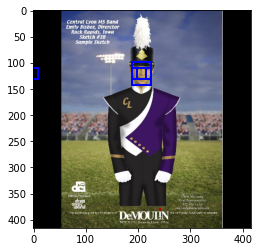

tensor([[0.4962, 0.2897, 0.0882, 0.1076]])
tensor([[0.4962, 0.2897, 0.0882, 0.1076],
        [0.4962, 0.2897, 0.0882, 0.0538],
        [0.4962, 0.2897, 0.0441, 0.0538],
        [0.0000, 0.2897, 0.0441, 0.0538]])
tensor([[1.0000, 0.5000, 0.2500, 0.0000]])
tensor([[1.0000, 0.5000, 0.2500, 0.0000]])


In [22]:
import copy
train_loader, test_loader, train_loader_evaluation = UTILS.get_loaders()
x,y = iter(train_loader_evaluation).next()
bboxes_batch = UTILS.cellvectors_to_bboxes(y, CONFIG.ANCHORS)
bboxes = UTILS.non_max_suppression(bboxes_batch[0], iou_threshold=1, threshold=0.7)
# print(bboxes_batch)
bboxes[1][3] = bboxes[1][3]/2
bboxes[2][2] = bboxes[2][2]/2
bboxes[2][3] = bboxes[2][3]/2
bboxes.append(copy.copy(bboxes[2]))
bboxes[3][0] = 0

# print(bboxes)

UTILS.plot_image(x[0].permute(1, 2, 0).to("cpu"),bboxes)

reference = torch.Tensor([bboxes[0][0:4]])
bboxes_tensor = torch.Tensor([box[0:4] for box in bboxes])
print(reference)
print(bboxes_tensor)

print(UTILS.intersection_over_union(reference,bboxes_tensor,"cxcywh"))
print(UTILS.intersection_over_union(reference,bboxes_tensor,"xywh"))

# train method

In [23]:
model = YOLOv3().to(CONFIG.DEVICE)

  0%|          | 0/250 [00:00<?, ?it/s]

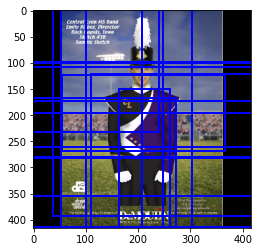

predicted boxvectors:
tensor([[0.7263, 0.5465, 2.5600, 6.1898, 0.4060]], grad_fn=<IndexBackward>)
target boxvectors:
tensor([[0.4500, 0.7655, 0.0882, 0.1076, 1.0000]])
loss: 494.48956298828125


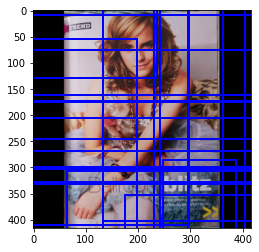

predicted boxvectors:
tensor([[0.4317, 0.5212, 2.2308, 4.7069, 0.4674]], grad_fn=<IndexBackward>)
target boxvectors:
tensor([[0.2764, 0.3972, 0.1834, 0.2367, 1.0000]])
loss: 287.497802734375


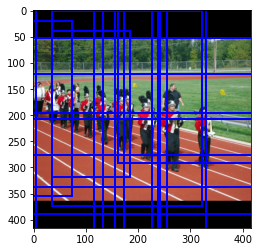

predicted boxvectors:
tensor([[ 0.7109,  0.4848,  2.8556,  8.8689,  0.5822],
        [ 0.6386,  0.5307,  2.3061,  5.0288,  0.4648],
        [ 0.6275,  0.4994,  3.4988,  3.3646,  0.5466],
        [ 0.5258,  0.6812,  3.0024,  3.2989,  0.5211],
        [ 0.5720,  0.5380,  3.3835,  3.4792,  0.7128],
        [ 0.7577,  0.6240,  2.0680,  5.5186,  0.6263],
        [ 0.6921,  0.5073,  3.9721,  9.6514,  0.5910],
        [ 0.5535,  0.4786,  4.0818, 10.8007,  0.4689],
        [ 0.7526,  0.6429,  3.9215,  6.8189,  0.4342],
        [ 0.5814,  0.5657,  3.6818,  5.4406,  0.5832],
        [ 0.5128,  0.6317,  3.8322,  2.4523,  0.6018],
        [ 0.5628,  0.4838,  4.3851,  5.2880,  0.3731],
        [ 0.7464,  0.6610,  4.7108,  4.8730,  0.3525],
        [ 0.3997,  0.5913,  4.9145,  9.0264,  0.3885],
        [ 0.5248,  0.6085,  2.6225,  3.3278,  0.7599],
        [ 0.7086,  0.5775,  3.4624,  4.0657,  0.2809],
        [ 0.7092,  0.4234,  5.1840,  3.9376,  0.3851],
        [ 0.3238,  0.6146,  7.3033,  6.6806

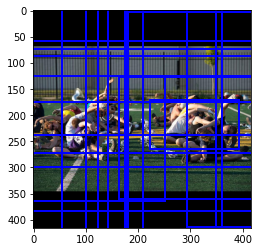

  0%|          | 1/250 [00:01<06:43,  1.62s/it]

predicted boxvectors:
tensor([[ 0.5289,  0.5107,  1.5184,  1.0362,  0.5939],
        [ 0.6285,  0.5957,  1.7512,  4.4626,  0.5426],
        [ 0.7687,  0.4878,  0.9426,  3.7413,  0.4390],
        [ 0.7359,  0.6142,  0.3175,  0.3396,  0.4506],
        [ 0.6654,  0.4834,  0.7446,  3.6374,  0.5201],
        [ 0.5541,  0.6407,  0.9210,  0.7800,  0.6274],
        [ 0.4939,  0.5929,  1.1817,  0.7761,  0.6996],
        [ 0.5371,  0.4990,  0.9161,  0.7177,  0.3966],
        [ 0.4111,  0.4003,  4.2629, 10.3330,  0.3315]],
       grad_fn=<IndexBackward>)
target boxvectors:
tensor([[0.7041, 0.9073, 0.0391, 0.0351, 1.0000],
        [0.7700, 0.4314, 0.0322, 0.0283, 1.0000],
        [0.1621, 0.9101, 0.0488, 0.0351, 1.0000],
        [0.0059, 0.1612, 0.0430, 0.0254, 1.0000],
        [0.4331, 0.6626, 0.0361, 0.0303, 1.0000],
        [0.2061, 0.2464, 0.0547, 0.0420, 1.0000],
        [0.5820, 0.3606, 0.0332, 0.0420, 1.0000],
        [0.6040, 0.1702, 0.0615, 0.0400, 1.0000],
        [0.6489, 0.2437, 0.0439

 20%|██        | 50/250 [00:42<02:48,  1.19it/s]

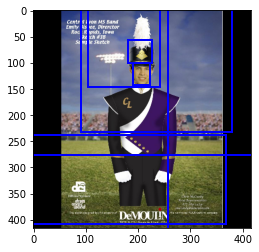

predicted boxvectors:
tensor([[0.4499, 0.7680, 0.0798, 0.1023, 0.9358]], grad_fn=<IndexBackward>)
target boxvectors:
tensor([[0.4500, 0.7655, 0.0882, 0.1076, 1.0000]])
loss: 6.8610358238220215


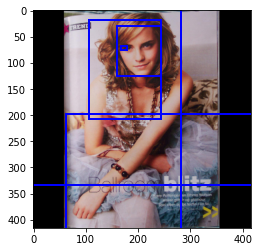

predicted boxvectors:
tensor([[0.2790, 0.3955, 0.2025, 0.2316, 0.9108]], grad_fn=<IndexBackward>)
target boxvectors:
tensor([[0.2764, 0.3972, 0.1834, 0.2367, 1.0000]])
loss: 3.6609137058258057


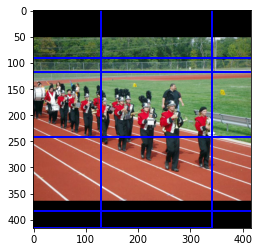

predicted boxvectors:
tensor([[0.4307, 0.4890, 0.0101, 0.0141, 0.0217],
        [0.0830, 0.4827, 0.0063, 0.0074, 0.0400],
        [0.1688, 0.8256, 0.0129, 0.0158, 0.0183],
        [0.3808, 0.6064, 0.0175, 0.0252, 0.1099],
        [0.3318, 0.1506, 0.0137, 0.0156, 0.0094],
        [0.1460, 0.2130, 0.0170, 0.0142, 0.0204],
        [0.2136, 0.4019, 0.0156, 0.0192, 0.0331],
        [0.1743, 0.3404, 0.0169, 0.0190, 0.0283],
        [0.6094, 0.7994, 0.0211, 0.0182, 0.0259],
        [0.2849, 0.8069, 0.0234, 0.0223, 0.0599],
        [0.2089, 0.1577, 0.0234, 0.0302, 0.0964],
        [0.1223, 0.6408, 0.0100, 0.0136, 0.0092],
        [0.1179, 0.7296, 0.0126, 0.0149, 0.0320],
        [0.5915, 0.4272, 0.0091, 0.0110, 0.0283],
        [0.8861, 0.1164, 0.0153, 0.0163, 0.0392],
        [0.3013, 0.4461, 0.0212, 0.0212, 0.0256],
        [0.7621, 0.6274, 0.0164, 0.0174, 0.0327],
        [0.2967, 0.4237, 0.0106, 0.0144, 0.3808],
        [0.4821, 0.3785, 0.0097, 0.0134, 0.0529],
        [0.6349, 0.3856, 0.0

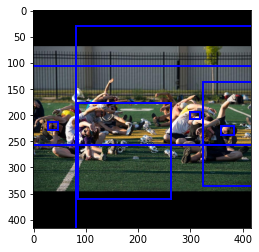

 20%|██        | 51/250 [00:44<03:28,  1.05s/it]

predicted boxvectors:
tensor([[0.6839, 0.8663, 0.0390, 0.0357, 0.0375],
        [0.7479, 0.4426, 0.0321, 0.0285, 0.0143],
        [0.1796, 0.8725, 0.0472, 0.0343, 0.0229],
        [0.0972, 0.1762, 0.0428, 0.0252, 0.0276],
        [0.4124, 0.6729, 0.0357, 0.0292, 0.0558],
        [0.2239, 0.2608, 0.0545, 0.0411, 0.0952],
        [0.5821, 0.3341, 0.0334, 0.0417, 0.0836],
        [0.5866, 0.1991, 0.0612, 0.0400, 0.1604],
        [0.6460, 0.2447, 0.0437, 0.0318, 0.6073]], grad_fn=<IndexBackward>)
target boxvectors:
tensor([[0.7041, 0.9073, 0.0391, 0.0351, 1.0000],
        [0.7700, 0.4314, 0.0322, 0.0283, 1.0000],
        [0.1621, 0.9101, 0.0488, 0.0351, 1.0000],
        [0.0059, 0.1612, 0.0430, 0.0254, 1.0000],
        [0.4331, 0.6626, 0.0361, 0.0303, 1.0000],
        [0.2061, 0.2464, 0.0547, 0.0420, 1.0000],
        [0.5820, 0.3606, 0.0332, 0.0420, 1.0000],
        [0.6040, 0.1702, 0.0615, 0.0400, 1.0000],
        [0.6489, 0.2437, 0.0439, 0.0322, 1.0000]])
loss: 4.513020038604736


 40%|████      | 100/250 [01:25<02:05,  1.19it/s]

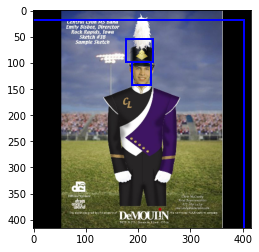

predicted boxvectors:
tensor([[0.4499, 0.7653, 0.0882, 0.1081, 0.9459]], grad_fn=<IndexBackward>)
target boxvectors:
tensor([[0.4500, 0.7655, 0.0882, 0.1076, 1.0000]])
loss: 1.777369499206543


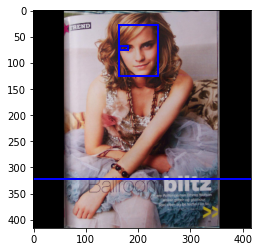

predicted boxvectors:
tensor([[0.2753, 0.3987, 0.1835, 0.2328, 0.9316]], grad_fn=<IndexBackward>)
target boxvectors:
tensor([[0.2764, 0.3972, 0.1834, 0.2367, 1.0000]])
loss: 2.276465892791748


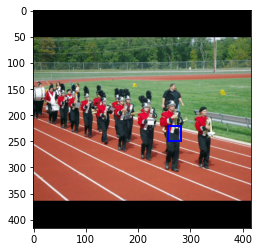

predicted boxvectors:
tensor([[0.4142, 0.4848, 0.0108, 0.0148, 0.1115],
        [0.0631, 0.4613, 0.0069, 0.0079, 0.0574],
        [0.1450, 0.8542, 0.0139, 0.0170, 0.0401],
        [0.3668, 0.5980, 0.0166, 0.0245, 0.2047],
        [0.3619, 0.1130, 0.0149, 0.0168, 0.0631],
        [0.1757, 0.2234, 0.0178, 0.0148, 0.0372],
        [0.2258, 0.4512, 0.0156, 0.0195, 0.0585],
        [0.1119, 0.3000, 0.0165, 0.0185, 0.0592],
        [0.6873, 0.8500, 0.0203, 0.0174, 0.0567],
        [0.2841, 0.8130, 0.0224, 0.0216, 0.1199],
        [0.1875, 0.1047, 0.0224, 0.0291, 0.0621],
        [0.0954, 0.6334, 0.0109, 0.0151, 0.0059],
        [0.0793, 0.7221, 0.0139, 0.0174, 0.0398],
        [0.5805, 0.4361, 0.0100, 0.0122, 0.1304],
        [0.9115, 0.0874, 0.0154, 0.0166, 0.0245],
        [0.2666, 0.4496, 0.0204, 0.0207, 0.0317],
        [0.8279, 0.6435, 0.0155, 0.0168, 0.0401],
        [0.2965, 0.4266, 0.0118, 0.0157, 0.3334],
        [0.4790, 0.3833, 0.0108, 0.0148, 0.1667],
        [0.6406, 0.3804, 0.0

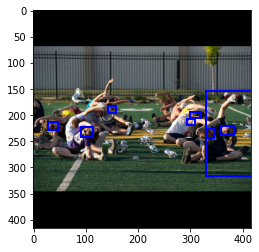

 40%|████      | 101/250 [01:27<02:35,  1.04s/it]

predicted boxvectors:
tensor([[0.6960, 0.8948, 0.0402, 0.0359, 0.1298],
        [0.7526, 0.4382, 0.0313, 0.0277, 0.1214],
        [0.1756, 0.8892, 0.0491, 0.0353, 0.1126],
        [0.0633, 0.1575, 0.0442, 0.0261, 0.0399],
        [0.4258, 0.6603, 0.0357, 0.0297, 0.4978],
        [0.2163, 0.2474, 0.0556, 0.0426, 0.6014],
        [0.5815, 0.3567, 0.0328, 0.0416, 0.5374],
        [0.6024, 0.1804, 0.0608, 0.0394, 0.3770],
        [0.6507, 0.2423, 0.0426, 0.0315, 0.7855]], grad_fn=<IndexBackward>)
target boxvectors:
tensor([[0.7041, 0.9073, 0.0391, 0.0351, 1.0000],
        [0.7700, 0.4314, 0.0322, 0.0283, 1.0000],
        [0.1621, 0.9101, 0.0488, 0.0351, 1.0000],
        [0.0059, 0.1612, 0.0430, 0.0254, 1.0000],
        [0.4331, 0.6626, 0.0361, 0.0303, 1.0000],
        [0.2061, 0.2464, 0.0547, 0.0420, 1.0000],
        [0.5820, 0.3606, 0.0332, 0.0420, 1.0000],
        [0.6040, 0.1702, 0.0615, 0.0400, 1.0000],
        [0.6489, 0.2437, 0.0439, 0.0322, 1.0000]])
loss: 2.3177971839904785


 60%|██████    | 150/250 [02:08<01:23,  1.20it/s]

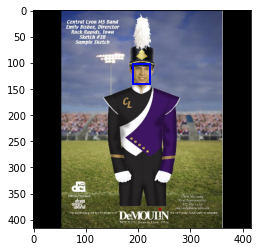

predicted boxvectors:
tensor([[0.4502, 0.7737, 0.0716, 0.0922, 0.5241]], grad_fn=<IndexBackward>)
target boxvectors:
tensor([[0.4500, 0.7655, 0.0882, 0.1076, 1.0000]])
loss: 2.753103256225586


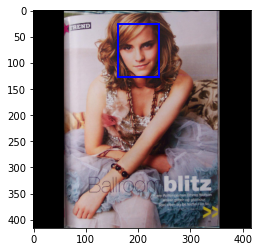

predicted boxvectors:
tensor([[0.2790, 0.3919, 0.1572, 0.2291, 0.7750]], grad_fn=<IndexBackward>)
target boxvectors:
tensor([[0.2764, 0.3972, 0.1834, 0.2367, 1.0000]])
loss: 1.9702425003051758


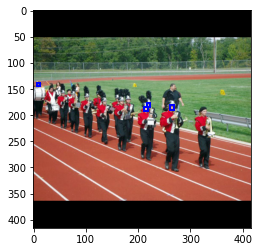

predicted boxvectors:
tensor([[0.4082, 0.4843, 0.0104, 0.0140, 0.2436],
        [0.0497, 0.4533, 0.0066, 0.0076, 0.0195],
        [0.1372, 0.8710, 0.0132, 0.0163, 0.0435],
        [0.3607, 0.6070, 0.0168, 0.0255, 0.2465],
        [0.3758, 0.0904, 0.0142, 0.0157, 0.0703],
        [0.1899, 0.2339, 0.0169, 0.0142, 0.0900],
        [0.2239, 0.4528, 0.0150, 0.0191, 0.0695],
        [0.0923, 0.2982, 0.0163, 0.0185, 0.0616],
        [0.7136, 0.8693, 0.0203, 0.0174, 0.0443],
        [0.2814, 0.8073, 0.0220, 0.0221, 0.1843],
        [0.1687, 0.0926, 0.0219, 0.0299, 0.0274],
        [0.0809, 0.6422, 0.0106, 0.0147, 0.0496],
        [0.0563, 0.7177, 0.0138, 0.0168, 0.0423],
        [0.5912, 0.4384, 0.0098, 0.0118, 0.2239],
        [0.9165, 0.0782, 0.0155, 0.0167, 0.0259],
        [0.2544, 0.4449, 0.0211, 0.0213, 0.4726],
        [0.8518, 0.6395, 0.0162, 0.0173, 0.1810],
        [0.3011, 0.4241, 0.0113, 0.0151, 0.4391],
        [0.4688, 0.3782, 0.0103, 0.0141, 0.3332],
        [0.6453, 0.3864, 0.0

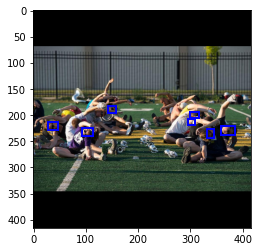

 60%|██████    | 151/250 [02:09<01:43,  1.04s/it]

predicted boxvectors:
tensor([[0.6925, 0.9003, 0.0384, 0.0355, 0.4091],
        [0.7637, 0.4325, 0.0316, 0.0284, 0.3375],
        [0.1698, 0.9001, 0.0441, 0.0323, 0.3782],
        [0.0463, 0.1670, 0.0410, 0.0250, 0.0285],
        [0.4339, 0.6584, 0.0351, 0.0290, 0.5707],
        [0.2047, 0.2444, 0.0518, 0.0392, 0.6240],
        [0.5700, 0.3582, 0.0334, 0.0428, 0.5220],
        [0.5909, 0.1857, 0.0632, 0.0429, 0.3206],
        [0.6490, 0.2453, 0.0459, 0.0339, 0.6906]], grad_fn=<IndexBackward>)
target boxvectors:
tensor([[0.7041, 0.9073, 0.0391, 0.0351, 1.0000],
        [0.7700, 0.4314, 0.0322, 0.0283, 1.0000],
        [0.1621, 0.9101, 0.0488, 0.0351, 1.0000],
        [0.0059, 0.1612, 0.0430, 0.0254, 1.0000],
        [0.4331, 0.6626, 0.0361, 0.0303, 1.0000],
        [0.2061, 0.2464, 0.0547, 0.0420, 1.0000],
        [0.5820, 0.3606, 0.0332, 0.0420, 1.0000],
        [0.6040, 0.1702, 0.0615, 0.0400, 1.0000],
        [0.6489, 0.2437, 0.0439, 0.0322, 1.0000]])
loss: 2.245858669281006


 80%|████████  | 200/250 [02:50<00:42,  1.17it/s]

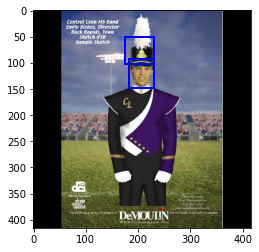

predicted boxvectors:
tensor([[0.4507, 0.7610, 0.0999, 0.1175, 0.8745]], grad_fn=<IndexBackward>)
target boxvectors:
tensor([[0.4500, 0.7655, 0.0882, 0.1076, 1.0000]])
loss: 2.770059823989868


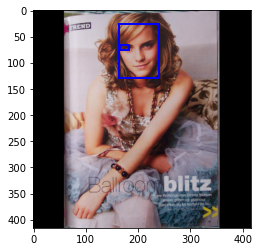

predicted boxvectors:
tensor([[0.2824, 0.4016, 0.2067, 0.2641, 0.8786]], grad_fn=<IndexBackward>)
target boxvectors:
tensor([[0.2764, 0.3972, 0.1834, 0.2367, 1.0000]])
loss: 1.9128673076629639


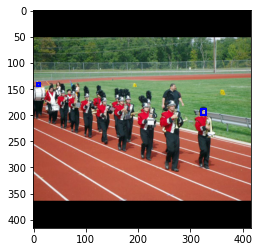

predicted boxvectors:
tensor([[0.3914, 0.4891, 0.0082, 0.0117, 0.3064],
        [0.0361, 0.4344, 0.0052, 0.0061, 0.0196],
        [0.1201, 0.8734, 0.0113, 0.0138, 0.0747],
        [0.3648, 0.5798, 0.0190, 0.0269, 0.2767],
        [0.3589, 0.0873, 0.0123, 0.0141, 0.0837],
        [0.1780, 0.2091, 0.0158, 0.0130, 0.3765],
        [0.2176, 0.4449, 0.0151, 0.0187, 0.4027],
        [0.0721, 0.2681, 0.0168, 0.0189, 0.0830],
        [0.7100, 0.8593, 0.0215, 0.0187, 0.0944],
        [0.2796, 0.7993, 0.0250, 0.0237, 0.2530],
        [0.1772, 0.0897, 0.0257, 0.0335, 0.0390],
        [0.0798, 0.6379, 0.0079, 0.0111, 0.0543],
        [0.0543, 0.7318, 0.0099, 0.0122, 0.0322],
        [0.5971, 0.4334, 0.0076, 0.0093, 0.1729],
        [0.9238, 0.0713, 0.0146, 0.0158, 0.0209],
        [0.2648, 0.4299, 0.0214, 0.0223, 0.3521],
        [0.8543, 0.6449, 0.0172, 0.0184, 0.1123],
        [0.2876, 0.4201, 0.0079, 0.0112, 0.1669],
        [0.4698, 0.3694, 0.0072, 0.0105, 0.1567],
        [0.6392, 0.3751, 0.0

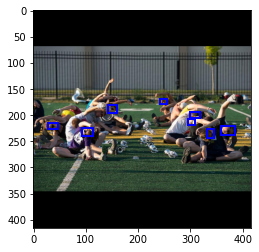

 80%|████████  | 201/250 [02:52<00:50,  1.04s/it]

predicted boxvectors:
tensor([[0.7051, 0.9036, 0.0401, 0.0359, 0.5514],
        [0.7652, 0.4330, 0.0301, 0.0271, 0.4186],
        [0.1679, 0.9010, 0.0464, 0.0337, 0.4253],
        [0.0439, 0.1539, 0.0443, 0.0260, 0.0480],
        [0.4257, 0.6668, 0.0360, 0.0300, 0.5159],
        [0.2086, 0.2488, 0.0560, 0.0424, 0.6987],
        [0.5787, 0.3560, 0.0330, 0.0418, 0.6242],
        [0.6066, 0.1749, 0.0602, 0.0394, 0.5805],
        [0.6524, 0.2419, 0.0426, 0.0317, 0.7573]], grad_fn=<IndexBackward>)
target boxvectors:
tensor([[0.7041, 0.9073, 0.0391, 0.0351, 1.0000],
        [0.7700, 0.4314, 0.0322, 0.0283, 1.0000],
        [0.1621, 0.9101, 0.0488, 0.0351, 1.0000],
        [0.0059, 0.1612, 0.0430, 0.0254, 1.0000],
        [0.4331, 0.6626, 0.0361, 0.0303, 1.0000],
        [0.2061, 0.2464, 0.0547, 0.0420, 1.0000],
        [0.5820, 0.3606, 0.0332, 0.0420, 1.0000],
        [0.6040, 0.1702, 0.0615, 0.0400, 1.0000],
        [0.6489, 0.2437, 0.0439, 0.0322, 1.0000]])
loss: 2.136275291442871


100%|██████████| 250/250 [03:33<00:00,  1.17it/s]


In [24]:
import torch
import torch.optim as optim

from tqdm import tqdm

import warnings
from IPython.display import clear_output
from sklearn.model_selection import KFold


def train_model(model, train_loader, epochs):


    optimizer = optim.Adam(
        model.parameters(), lr=CONFIG.LEARNING_RATE, weight_decay=CONFIG.WEIGHT_DECAY
    )

    loss_fn = YoloLoss()

    for epoch in tqdm(range(epochs)):
        for i, (x, y) in enumerate(train_loader_evaluation):

            x = x.to(CONFIG.DEVICE)

            model.train()

            optimizer.zero_grad()

            out = model(x)

            out_cpu = [output.to("cpu") for output in out]


            loss = (
                    loss_fn(out[0], y[0].to(CONFIG.DEVICE))
                    + loss_fn(out[1], y[1].to(CONFIG.DEVICE))
                    + loss_fn(out[2], y[2].to(CONFIG.DEVICE))
                )

            loss.backward()

            optimizer.step()

            if epoch % 50 == 0:

                bboxes_batch = UTILS.cellvectors_to_bboxes(out_cpu, CONFIG.ANCHORS)

                bboxes = UTILS.non_max_suppression(bboxes_batch[0], threshold=0.5)

                UTILS.plot_image(x[0].permute(1, 2, 0).to("cpu"), bboxes)

                print("predicted boxvectors:")

                print(out_cpu[0][loss_fn.obj_present(y[0])])

                print("target boxvectors:")

                print(y[0][loss_fn.obj_present(y[0])])

                
                print("loss: {}".format(loss))

                # mean_ap = UTILS.evaluate_model(train_loader_evaluation, model)

                # print("map: {}".format(mean_ap))


train_loader, test_loader, train_loader_evaluation = UTILS.get_loaders()
        
train_model(model, train_loader_evaluation, 250)

In [27]:
UTILS.evaluate_model(train_loader_evaluation, model)

100%|██████████| 5/5 [00:00<00:00,  8.87it/s]
0it [00:00, ?it/s]

calculating mAP:


0.0

  0%|          | 0/51 [00:00<?, ?it/s]

calculating mAP:
1.0


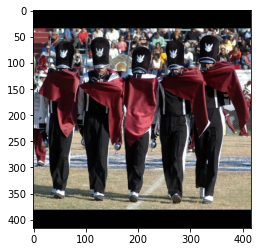

desired boxes:
tensor([0., 1., 0., 0., 0.], grad_fn=<SelectBackward>)
loss: 28.021339416503906


100%|██████████| 3/3 [00:00<00:00,  6.85it/s]
0it [00:00, ?it/s]
  2%|▏         | 1/51 [00:01<01:13,  1.47s/it]

calculating mAP:
map: 0.0


 49%|████▉     | 25/51 [00:20<00:20,  1.26it/s]

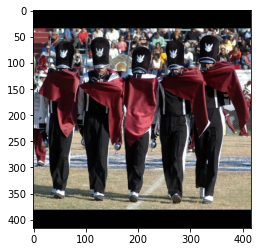

desired boxes:
tensor([0., 1., 0., 0., 0.], grad_fn=<SelectBackward>)
loss: 28.021339416503906


100%|██████████| 3/3 [00:00<00:00,  6.71it/s]
0it [00:00, ?it/s]
 51%|█████     | 26/51 [00:22<00:24,  1.00it/s]

calculating mAP:
map: 0.0


 98%|█████████▊| 50/51 [00:42<00:00,  1.13it/s]

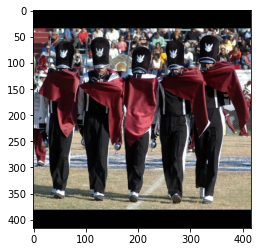

desired boxes:
tensor([0., 1., 0., 0., 0.], grad_fn=<SelectBackward>)
loss: 28.021339416503906


100%|██████████| 3/3 [00:00<00:00,  6.51it/s]
0it [00:00, ?it/s]
100%|██████████| 51/51 [00:43<00:00,  1.17it/s]

calculating mAP:
map: 0.0


In [130]:
#temporary training block to find the bug
import torch
import torch.optim as optim

from tqdm import tqdm

import warnings
from IPython.display import clear_output
from sklearn.model_selection import KFold

train_loader, test_loader, train_loader_evaluation = UTILS.get_loaders()

pred_boxes, true_boxes = UTILS.get_evaluation_bboxes3(train_loader_evaluation, model)
print(UTILS.mean_average_precision(true_boxes,true_boxes))


# print("goal")

# for index, (x, y) in enumerate(train_loader_evaluation):
#     bboxes_batch = cellvectors_to_bboxes(y, CONFIG.ANCHORS)
    
#     bboxes = UTILS.non_max_suppression(bboxes_batch[0], iou_threshold=1, threshold=0.7, box_format="midpoint")

#     UTILS.plot_image(x[0].permute(1, 2, 0).to("cpu"), bboxes)

    
#     if index == 3:
#         print("target_shape:")
#         print(y[0].shape)
#         print(y[1].shape)
#         print(y[2].shape)


#         #find position of bbox vector
#         for scale in range(len(y)):
#             vector = y[scale][0]
#             for anchor in range(len(vector)):
#                 for x_pos in range(len(vector[anchor])):
#                     for y_pos in range(len(vector[anchor, x_pos])):
#                         if vector[anchor,x_pos,y_pos,4] == 1:
#                             print("position: {}".format((anchor, x_pos, y_pos)))
#                             print("box: {}".format(vector[anchor, x_pos, y_pos]))


optimizer = optim.Adam(
        model.parameters(), lr=CONFIG.LEARNING_RATE, weight_decay=CONFIG.WEIGHT_DECAY
    )

loss_fn = YoloLoss()

for epoch in tqdm(range(51)):
    for i, (x, y) in enumerate(train_loader_evaluation):

        x = x.to(CONFIG.DEVICE)

        optimizer.zero_grad()

        out = model(x)

        # print("model output_shape:")
        # print(out[0].shape)
        # print(out[1].shape)
        # print(out[2].shape)

        out_cpu = [output.to("cpu") for output in out]


        loss = (
                loss_fn(out[0], y[0].to(CONFIG.DEVICE))
                + loss_fn(out[1], y[1].to(CONFIG.DEVICE))
                + loss_fn(out[2], y[2].to(CONFIG.DEVICE))
            )

        loss.backward()

        optimizer.step()

        if epoch % 25 == 0 and i == 2:

            bboxes_batch = cellvectors_to_bboxes(out_cpu, CONFIG.ANCHORS)

            bboxes = UTILS.non_max_suppression(bboxes_batch[0], iou_threshold=1, threshold=0.7, box_format="midpoint")

            UTILS.plot_image(x[0].permute(1, 2, 0).to("cpu"), bboxes)

            print("desired boxes:")
            print(out_cpu[0][0, 0,3,6])
            
            print("loss: {}".format(loss))

            mean_ap = UTILS.evaluate_model(train_loader_evaluation, model)
            print("map: {}".format(mean_ap))

In [9]:
"""
Main file for training Yolo model on WIDER Face
"""

import torch
import torch.optim as optim

from tqdm import tqdm

import warnings
from IPython.display import clear_output
from sklearn.model_selection import KFold

warnings.filterwarnings("ignore")

torch.backends.cudnn.benchmark = True


def train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors):
    loop = tqdm(train_loader, leave=True)
    losses = []
    for batch_idx, (x, y) in enumerate(loop):
        x = x.to(CONFIG.DEVICE)
        y0, y1, y2 = (
            y[0].to(CONFIG.DEVICE),
            y[1].to(CONFIG.DEVICE),
            y[2].to(CONFIG.DEVICE),
        )

        with torch.cuda.amp.autocast():
            out = model(x)
            loss = (
                loss_fn(out[0], y0, scaled_anchors[0])
                + loss_fn(out[1], y1, scaled_anchors[1])
                + loss_fn(out[2], y2, scaled_anchors[2])
            )

        losses.append(loss.item())
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update progress bar
        mean_loss = sum(losses) / len(losses)
        loop.set_postfix(loss=mean_loss)


# based on https://www.machinecurve.com/index.php/2021/02/03/how-to-use-k-fold-cross-validation-with-pytorch/
def kfold_train(model, dataset, n_fold = 5):
    mAPs = []
    optimizer = optim.Adam(
        model.parameters(), lr=CONFIG.LEARNING_RATE, weight_decay=CONFIG.WEIGHT_DECAY
    )
    loss_fn = YoloLoss()
    scaler = torch.cuda.amp.GradScaler()
    if CONFIG.LOAD_MODEL:
        UTILS.load_checkpoint(
            CONFIG.CHECKPOINT_FILE, model, optimizer, CONFIG.LEARNING_RATE
        )

    scaled_anchors = (
        torch.tensor(CONFIG.ANCHORS)
        * torch.tensor(CONFIG.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
    ).to(CONFIG.DEVICE)

    kfold = KFold(n_splits=n_fold,shuffle=True)

    for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
        print("Fold nr: {}".format(fold))
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        test_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

        trainloader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=CONFIG.BATCH_SIZE,
                      num_workers=CONFIG.NUM_WORKERS,
                      pin_memory=CONFIG.PIN_MEMORY, 
                      shuffle=True,
                      drop_last=False,
                      sampler=train_subsampler
        )
        testloader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=CONFIG.BATCH_SIZE,
                      num_workers=CONFIG.NUM_WORKERS,
                      pin_memory=CONFIG.PIN_MEMORY, 
                      shuffle=True,
                      drop_last=False,
                      sampler=test_subsampler
        )


        model.apply(reset_weights)

        for epoch in range(500): #range(CONFIG.NUM_EPOCHS):
            if epoch > 0 and epoch % 10 == 0:
                clear_output(wait=True)
                print("Epoch {}".format(epoch))
            train_fn(trainloader, model, optimizer, loss_fn, scaler, scaled_anchors)

            if CONFIG.SAVE_MODEL:
                UTILS.save_checkpoint(model, optimizer, filename=f"checkpoint.pth.tar")

            # every so many epochs, evaluate the model
            # if epoch > 0 and epoch % 10 == 0:
            #     mAP = evaluate_model(testloader, model)
            #     print("mAP = {}".format(mAP))
                
            #     mAPs.append(mAP.tolist())
            #     print(mAPs)

def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

def main(model):
    mAPs = []
    optimizer = optim.Adam(
        model.parameters(), lr=CONFIG.LEARNING_RATE, weight_decay=CONFIG.WEIGHT_DECAY
    )
    loss_fn = YoloLoss()
    scaler = torch.cuda.amp.GradScaler()

    train_loader, test_loader, train_loader_evaluation = UTILS.get_loaders()

    if CONFIG.LOAD_MODEL:
        UTILS.load_checkpoint(
            CONFIG.CHECKPOINT_FILE, model, optimizer, CONFIG.LEARNING_RATE
        )

    scaled_anchors = (
        torch.tensor(CONFIG.ANCHORS)
        * torch.tensor(CONFIG.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
    ).to(CONFIG.DEVICE)

    for epoch in range(1000): #range(CONFIG.NUM_EPOCHS):
        if epoch > 0 and epoch % 10 == 0:
            clear_output(wait=True)
            print("Epoch {}".format(epoch))
        train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors)

        if CONFIG.SAVE_MODEL:
           UTILS.save_checkpoint(model, optimizer, filename=f"checkpoint.pth.tar")

        # every so many epochs, evaluate the model
        if epoch > 0 and epoch % 10 == 0:

            mAP = evaluate_model(train_loader_evaluation, model)
            print("mAP = {}".format(mAP))
            
            mAPs.append(mAP.tolist())
            # print(mAPs)
            # print(f"Class accuracy is: {class_accuracy:2f}%")
            # print(f"No obj accuracy is: {no_obj_accuracy:2f}%")
            # print(f"Obj accuracy is: {obj_accuracy:2f}%")
    
    x = np.linspace(10,10+len(mAPs)*10,len(mAPs))
    plt.plot(x,mAPs)
            
main(model)

  0%|          | 0/1074 [00:03<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 2.64 GiB already allocated; 0 bytes free; 2.67 GiB reserved in total by PyTorch)

In [ ]:
optimizer = optim.Adam(
    model.parameters(), lr=CONFIG.LEARNING_RATE, weight_decay=CONFIG.WEIGHT_DECAY
)
UTILS.save_checkpoint(model, optimizer, filename=CONFIG.CHECKPOINT_FILE)

In [ ]:
train_loader, test_loader, train_loader_evaluation = UTILS.get_loaders()
UTILS.plot_examples(train_loader_evaluation, model)